# Analysing Results

To run this experiment, first start by generating 100 configurations (the first is the default configuration, which means 99 are sampled randomly):
```console
lcdb create -w lcdb.workflow.sklearn.LibLinearWorkflow -n 100 -o configs.csv
```
This will create the `config.csv` file.


Then run the experiment using these configurations:
```console
lcdb run --openml-id 3 -w lcdb.workflow.sklearn.LibLinearWorkflow --monotonic --max-evals 100 -t 1800 --initial-configs configs.csv
```
this will create the `results.csv` file.

In [1]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis.hpo import filter_failed_objectives
from deephyper.analysis._matplotlib import update_matplotlib_rc, figure_size

update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [2]:
# Check the configs.csv to see if the same configuration are indeed evaluated
ip_df = pd.read_csv("configs.csv")
ip_df

,C,class_weight,dual,fit_intercept,intercept_scaling,loss,max_iter,multiclass,penalty,pp@cat_encoder,pp@decomposition,pp@featuregen,pp@featureselector,pp@scaler,tol,pp@kernel_pca_kernel,pp@kernel_pca_n_components,pp@poly_degree,pp@selectp_percentile,pp@std_with_std
0,1.000000e+00,none,True,True,1.000000,squared_hinge,1000,ovr,l2,ordinal,none,none,generic,none,0.001000,linear,0.250000,2,25,True
1,3.108149e+05,none,True,True,36.831068,hinge,113,ovr,l2,ordinal,fastica,poly,none,minmax,0.505605,linear,0.250000,4,25,True
2,1.065894e-04,balanced,True,True,102.147075,hinge,343,ovr,l2,onehot,fastica,poly,generic,minmax,0.271613,linear,0.250000,3,25,True
3,2.134039e+10,none,True,False,246.606499,hinge,3417,ovr,l2,onehot,kernel_pca,none,selectp,none,0.066031,rbf,0.364675,2,28,True
4,6.139549e+00,none,False,True,6.736774,squared_hinge,364,ovo-scikit,l1,ordinal,ka_rbf,poly,none,minmax,0.052189,linear,0.250000,2,25,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,9.013790e+06,none,True,True,245.538166,hinge,972,ovr,l2,ordinal,kernel_pca,none,none,std,0.000287,rbf,0.551696,2,25,False
196,1.078628e+09,balanced,False,True,3.594297,squared_hinge,1607,ovo-scikit,l1,ordinal,ka_nystroem,poly,none,none,0.112891,linear,0.250000,2,25,True
197,2.043335e+11,balanced,True,False,42.240537,squared_hinge,195,ovo-scikit,l2,ordinal,none,none,selectp,minmax,0.144110,linear,0.250000,2,81,True
198,8.267585e+09,balanced,True,True,27.738812,hinge,1009,ovr,l2,onehot,lda,poly,selectp,minmax,0.000549,linear,0.250000,2,75,True


In [3]:
def prepare_df(df):
    """Prepare the dataframe for analysis. For example, load the arrays/list from json format.
    """

    df.sort_values("job_id", inplace=True)

    # Convert the string to JSON
    str_to_json = lambda x: x.replace("'", '"').replace("nan", "NaN").replace("inf", "Infinity")
    load_json = lambda x: json.loads(str_to_json(x))
    load_array = lambda x: np.array(load_json(x))

    # Load the arrays
    columns = ["m:fidelity_values", "m:score_types", "m:score_values"]
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(load_array)

    # Load the dicts
    columns = ["m:child_fidelities"]
    for col in columns:
        if col in df.columns:
            df[col] = df[col].map(load_json)

    return df

In [4]:
# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
r_df = pd.read_csv("results.csv")
r_df, r_df_failed = filter_failed_objectives(r_df)

r_df = prepare_df(r_df)
r_df

,p:C,p:class_weight,p:dual,p:fit_intercept,p:intercept_scaling,p:loss,p:max_iter,p:multiclass,p:penalty,p:pp@cat_encoder,...,m:child_fidelities,m:dataset_id,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:workflow_seed,m:traceback
0,1.000000e+00,none,True,True,1.000000,squared_hinge,1000,ovr,l2,ordinal,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
67,3.108149e+05,none,True,True,36.831068,hinge,113,ovr,l2,ordinal,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,"""Traceback (most recent call last):\n File ""/..."
12,2.134039e+10,none,True,False,246.606499,hinge,3417,ovr,l2,onehot,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
2,6.139549e+00,none,False,True,6.736774,squared_hinge,364,ovo-scikit,l1,ordinal,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
9,4.033909e-10,balanced,False,False,515.810626,squared_hinge,417,ovr,l2,onehot,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,3.247373e-02,none,True,True,333.514133,hinge,8005,ovo-scikit,l2,ordinal,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
194,9.180955e+04,none,False,True,13.246452,squared_hinge,458,ovr,l2,onehot,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
195,3.420824e-06,none,True,True,22.731285,hinge,1151,ovr,l2,ordinal,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN
196,1.767621e-06,balanced,True,False,482.327298,squared_hinge,348,ovo-scikit,l2,onehot,...,[],3,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,42,NaN


In [13]:
r_df_failed["objective"]

75     F_timeout_on_fit
109                   F
157    F_timeout_on_fit
Name: objective, dtype: object

In [5]:
idx = 0
print(r_df_failed.iloc[idx])
print(r_df_failed.iloc[idx]["m:traceback"])

p:C                                                                     44.178926
p:class_weight                                                               none
p:dual                                                                       True
p:fit_intercept                                                              True
p:intercept_scaling                                                     34.559207
p:loss                                                              squared_hinge
p:max_iter                                                                   5467
p:multiclass                                                                  ovr
p:penalty                                                                      l2
p:pp@cat_encoder                                                          ordinal
p:pp@decomposition                                                   agglomerator
p:pp@featuregen                                                              poly
p:pp@featuresele

In [6]:
sorted(r_df["objective"])

[0.42812,
 0.45,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.47812,
 0.48125,
 0.49062,
 0.49062,
 0.50313,
 0.50625,
 0.51562,
 0.51875,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.52188,
 0.53438,
 0.53438,
 0.5375,
 0.54062,
 0.55625,
 0.56563,
 0.56563,
 0.56875,
 0.57812,
 0.58125,
 0.59062,
 0.59688,
 0.6,
 0.60312,
 0.60312,
 0.61875,
 0.63125,
 0.64688,
 0.65,
 0.65,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.6

In [7]:
# Check the columns
r_df.columns.to_list()

['p:C',
 'p:class_weight',
 'p:dual',
 'p:fit_intercept',
 'p:intercept_scaling',
 'p:loss',
 'p:max_iter',
 'p:multiclass',
 'p:penalty',
 'p:pp@cat_encoder',
 'p:pp@decomposition',
 'p:pp@featuregen',
 'p:pp@featureselector',
 'p:pp@scaler',
 'p:tol',
 'p:pp@kernel_pca_kernel',
 'p:pp@kernel_pca_n_components',
 'p:pp@poly_degree',
 'p:pp@selectp_percentile',
 'p:pp@std_with_std',
 'objective',
 'job_id',
 'm:timestamp_submit',
 'm:timestamp_gather',
 'm:timestamp_start',
 'm:timestamp_end',
 'm:memory',
 'm:fidelity_unit',
 'm:fidelity_values',
 'm:score_types',
 'm:score_values',
 'm:time_types',
 'm:time_values',
 'm:child_fidelities',
 'm:dataset_id',
 'm:workflow',
 'm:valid_prop',
 'm:test_prop',
 'm:monotonic',
 'm:valid_seed',
 'm:test_seed',
 'm:workflow_seed',
 'm:traceback']

In [8]:
# Cumulated time
duration_wo_overheads = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).sum()
print(f"Cumulated time (without submit/gather overheads): {duration_wo_overheads:.2f} s.")

duration_w_overheads = (r_df["m:timestamp_gather"] - r_df["m:timestamp_submit"]).sum()
print(f"Cumulated time (with submit/gather overheads)   : {duration_w_overheads:.2f} s.")

ratio_overheads = (duration_w_overheads - duration_wo_overheads) / duration_wo_overheads
print(f"Overheads accounted for {ratio_overheads*100:.2f} % of the total time.\n")

# Real time
duration_run = (r_df["m:timestamp_gather"].max() - r_df["m:timestamp_submit"].min())
print(f"Real time of execution: {duration_run:.2f} s.")

Cumulated time (without submit/gather overheads): 4207.35 s.
Cumulated time (with submit/gather overheads)   : 4347.54 s.
Overheads accounted for 3.33 % of the total time.

Real time of execution: 607.73 s.


In [9]:
duration_job_mean = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).mean()
duration_job_std  = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).std()

print(f"Mean time per job: {duration_job_mean:.2f} s.")
print(f"Std  time per job: {duration_job_std:.2f} s.")

Mean time per job: 21.47 s.
Std  time per job: 53.91 s.


In [10]:
keys = ["m:fidelity_unit", "m:fidelity_values", "m:score_types"] 

for k in keys:
    print(f"{k[2:]}: {r_df[k][0]}")

fidelity_unit: samples
fidelity_values: [  16   23   32   45   64   91  128  181  256  362  512  724 1024 1448
 2048 2556]
score_types: ['accuracy' 'loss']


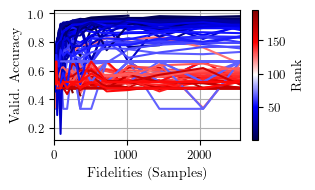

In [11]:
# Meaning of indexes
# fidelities, (train|valid|test), (accuracy|loss)

# Configuration of the plot
selected_split = "valid"
selected_score = "accuracy"

# Plotting
score_types = r_df["m:score_types"][0].tolist()
splits = ["train", "valid", "test"]
unit = r_df['m:fidelity_unit'][0]

idx_split = splits.index(selected_split)
idx_score = score_types.index(selected_score)

cmap = mpl.colormaps["seismic"]

fig = plt.figure()

# corresponds to iloc indexing
scores_max_fidelity = r_df["m:score_values"].map(lambda x: x[-1, idx_split, idx_score]).to_numpy()
ranking = rank(-scores_max_fidelity, decimals=3)
ranking_max = ranking.max()
for i in range(len(r_df)):
    fidelities = r_df.iloc[i]["m:fidelity_values"]
    scores = r_df.iloc[i]["m:score_values"][:, idx_split, idx_score]
    plt.plot(fidelities, scores, color=cmap(ranking[i]/ranking_max))

plt.xlabel(f"Fidelities ({unit.capitalize()})")
plt.ylabel(f"{selected_split.capitalize()}. {selected_score.capitalize()}")

plt.grid()

norm = mpl.cm.ScalarMappable(norm=None, cmap=cmap)
norm.set_clim(1, ranking_max)
cb = plt.colorbar(norm, ax=plt.gca(), label="Rank")
plt.xlim(0, fidelities.max())

plt.tight_layout()
plt.savefig(f"{unit}_{selected_split}-{selected_score}.png")
plt.show()